In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import nbimporter

sys.path.append('../')
from module import sun_position
import Weather as WEA

Importing Jupyter notebook from ..\module\sun_position.ipynb
Importing Jupyter notebook from Weather.ipynb


# 太陽位置を計算するモジュール

## 1. Functions  

任意の時刻・緯度・経度における太陽高度角・太陽方位角を計算する。

### 入力値  

$ Y $ ：西暦年（year）  
$ D $ ：1月1日を初日（$D=1$）とする計算対象日の年通算日 (day)  
$ T_m $ ：標準時 (h)  
$ \Phi $ ：計算対象地点の緯度 (°)  
$ L $ ：計算対象地点の経度 (°)  

### 出力値

$ h $ ：太陽高度角 (°)  
$ A $ ：太陽方位角 (°)  

### 計算方法

#### データ構造と値の範囲

$Y$・$D$・$T_m$・$\Phi$・$L$の組み合わせをクラス『sp＿input』と定義する。  
$h$は0°以上、90°以下の値をとる（地平：0°、天頂：90°）。  
$A$は-180°以上、180°以下の値をとる（東：-90°、南：0°、西：90°）。

#### 太陽高度角及び太陽方位角の計算

太陽高度角$ h $、太陽方位角$ A $の計算方法を以下に示す。  
（参考：拡張アメダス気象データ1981-2000解説書 8.1　太陽位置の計算）  

$$
\begin{eqnarray}
 &\displaystyle \sin h = \sin \Phi \cdot \sin \delta + \cos \Phi \cdot \cos \delta \cdot \cos t& \qquad\qquad\text{(1)} \nonumber\\
 \nonumber \\
 &\displaystyle \sin A = \frac{ \cos \delta \cdot \sin t }{ \cos h }& \qquad\qquad\text{(2)} \nonumber\\
 \nonumber \\
 &\displaystyle \cos A = \frac{ \sin h \cdot \sin \Phi - \sin \delta }{ \cos h \cdot \cos \phi }& \qquad\qquad\text{(3)} \nonumber\\
 \nonumber \\
 &\displaystyle t = 15 \cdot ( T_m - 12 ) + ( L - L_0 ) + E_t& \qquad\qquad\text{(4)} \nonumber\\
 \nonumber \\
 &\displaystyle \sin \delta = \cos ( v + \epsilon ) \cdot \sin \delta_0& \qquad\qquad\text{(5)} \nonumber\\
 \nonumber \\
 &\displaystyle E_t = (M - v) - \tan^{-1} \biggl[ \frac{ 0.043 \cdot \sin 2( v + \epsilon ) }{ 1 - 0.043 \cdot \cos 2(v + \epsilon) } \biggr]& \qquad\qquad\text{(6)} \nonumber\\
 \nonumber \\ 
 &\displaystyle v = M + 1.914 \cdot \sin M + 0.02 \cdot \sin(2M)& \qquad\qquad\text{(7)} \nonumber\\
 \nonumber \\
 &\displaystyle \epsilon = 12.3901 + 0.0172 \cdot \biggl( n + \frac{ M }{ 360 } \biggr)& \qquad\qquad\text{(8)} \nonumber\\
 \nonumber \\
 &\displaystyle M = \frac{ 360 \cdot (D - d_0) }{ D_{ay} }& \qquad\qquad\text{(9)} \nonumber\\
 \nonumber \\
 &\displaystyle d_0 = 3.71 + 0.2596 \cdot n - INT \biggl[ \frac{ n + 3 }{ 4 } \biggr]& \qquad\qquad\text{(10)} \nonumber\\
 \nonumber \\
 &\displaystyle n = Y - 1968& \qquad\qquad\text{(11)} \nonumber\\
 \nonumber \\
\end{eqnarray}
$$

ここで、  

$ \delta $ ：赤緯 (°)  
$ t $ ：時角 (°)  
$ L_0 $ ：標準時の地点の経度（=135.0（日本の場合）） (°)  
$ E_t $ ：均時差 (°)  
$ v $ ：真近点離角 (°)  
$ \epsilon $ ：近日点と冬至点の角度 (°)  
$ \delta_0 $ ：北半球の冬至の日赤緯（= -23.4393） (°)  
$ M $ ：平均近点離角 (°)  
$ n $ ：1968年との年差 (year)  
$ d_0 $ ：平均軌道上の近日点通過日（暦表時による1968年1月1日正午基準の日差）(day)  
$ D_{ay} $ ：近点年（近日点基準の公転周期日数）（= 365.2596） (day)  
$ INT[] $ ：小数点以下切り捨て  
$ Y $ ：西暦年 (year)  

である。  

In [12]:
#太陽位置の計算
#太陽高度角、太陽方位角
def solar_position(year, nday, tm, lat, lon):
    n = year - 1968. #式(11)
    d0 = 3.71 + 0.2596 * n - int((n + 3.) / 4.) #式(10)
    Day = 365.2596
    M = 360. * (nday - d0) / Day #式(9)
    eps = 12.3901 + 0.0172 * (n + M / 360.) #式(8)
    v = M + 1.914 * math.sin(math.radians(M)) + 0.02 * math.sin(math.radians(2. * M)) #式(7)
    veps = math.radians(v + eps)
    et = (M - v) - math.degrees(math.atan(0.043 * math.sin(2. * veps) / (1. - 0.043 * math.cos(2. * veps)))) #式(6)
    dlt0 = math.radians(-23.4393)
    sindlt = math.cos(veps) * math.sin(dlt0) #式(5)
    cosdlt = (abs(1. - sindlt ** 2.)) ** 0.5
    dlt = math.asin(sindlt)
    lons = 135.
    t = 15. * (tm - 12.) + (lon - lons) + et #式(4)
    latrad = math.radians(lat)
    trad = math.radians(t)
    
    hs, sin_hs, cos_hs = sun_position.calc_hs(latrad, dlt, trad)
    
    if sin_hs > 0.:
        A = sun_position.calc_Azs(latrad, dlt, trad, hs)
    else:
        A = 0.0

    return math.degrees(hs), math.degrees(A)

#### Example

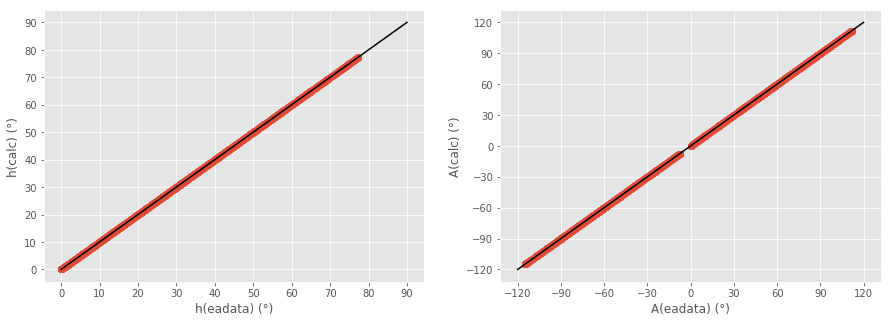

In [13]:
if __name__ == '__main__':

    location = '3639999'               #東京ID
    year = 1995                        #西暦年
    lat = 35. + 41.2 / 60.             #計算対象地点の緯度 (°)  
    lon = 139. + 45.9 / 60.            #計算対象地点の経度 (°)  

    sp_result = np.empty((5,8760))

    for i in range(0, 8760):
        nday = int((i + 1.) / 24.) + 1.
        tm = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.
        sp_result[0][i] = i + 1.                                           #年通算時間
        sp_result[1][i] = int((i + 1.) / 24.) + 1.                         #年通算日
        sp_result[2][i] = ((i + 1.) / 24. - int((i + 1.) / 24.)) * 24.     #時刻
        sp_result[3][i] = solar_position(year, nday, tm, lat, lon)[0]                         #太陽高度角
        sp_result[4][i] = solar_position(year, nday, tm, lat, lon)[1]                         #太陽方位角

    #np.savetxt(location + '_out_sp.csv', np.transpose(sp_result), fmt='%.10f', delimiter=',')

    #確認用気象データ読込
    wc = WEA.WeatherConfirm(location)

    #グラフの描画
    graph_num = 2
    ax = np.empty(graph_num, dtype = np.object)
    fig = plt.figure(figsize = (15, 5 * ((graph_num + 1) // 2)))
    plt.style.use('ggplot')

    gpc = 'C0'
    gxd = [[[r.w_h for r in wc.rows], [0,90]], [[r.w_A for r in wc.rows], [-120,120]]]
    gyd = [[sp_result[3][0:8760], [0,90]], [sp_result[4][0:8760], [-120,120]]]
    gxl = ['h(eadata) (°)','A(eadata) (°)']
    gyl = ['h(calc) (°)', 'A(calc) (°)']
    gxt = [[10 * i for i in range(10)], [30 * (i - 4) for i in range(9)]]
    gyt = [[10 * i for i in range(10)], [30 * (i - 4) for i in range(9)]]

    for i in range(graph_num):   
        ax[i] = fig.add_subplot((graph_num + 1) // 2, 2, i + 1)
        ax[i].scatter(gxd[i][0], gyd[i][0], color = gpc)
        ax[i].plot(gxd[i][1], gyd[i][1], color = (0,0,0))
        ax[i].set_xticks(gxt[i])
        ax[i].set_yticks(gyt[i])
        ax[i].set_xlabel(gxl[i], fontsize = 12)
        ax[i].set_ylabel(gyl[i], fontsize = 12)

    plt.show()